**Table of contents**<a id='toc0_'></a>    
- 1. [Preface](#toc1_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>Preface [&#128285;](#toc0_)

In [72]:
# Imports
%matplotlib widget
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import requests
import io

import os
import sys
# if my user name is gafarge then use the following path
if os.getlogin() == 'gafarge':
    sys.path.append('/home/gafarge/py_modules/my_modules')
    workdir = '/home/gafarge/'
elif os.getlogin() == 'root':
    sys.path.append('/Users/gaspard/work/py_modules/my_modules')
    workdir = '/Users/gaspard/work/'
from geostuff import transect

In [102]:
# Define functions
def b_positive(t, m, dmc):
    # find where M_ii < M_jj + dMc and t_ii < t_jj
    dt_mat = (t[np.newaxis, :] - t[:, np.newaxis]) / np.timedelta64(1, 'ms')  # ii > jj gives positive dt
    dm_mat = m[np.newaxis, :] - m[:, np.newaxis]

    pos_ii, pos_jj = np.where((dt_mat > 0.) & (dm_mat > dmc))

    # find the first event jj that satisfies the condition for each event ii
    dm_positive = []
    prev_ii = -1
    for id, ii in enumerate(pos_ii):
        if ii != prev_ii:
            dm_positive.append(dm_mat[ii, pos_jj[id]])
            prev_ii = ii

    dm_positive = np.array(dm_positive)
    b = 1/np.log(10) / (dm_positive - dmc).mean()
    return b, dm_positive

In [73]:
# Download usgs catalog
# Format
format_usgs = "format=csv"
format_isc = "format=text"  # something that looks like csv

# Date range
t0 = "2009-08-01"
t1 = "2024-04-04"
date_range = f"starttime={t0}&endtime={t1}" 

# Geographic range
minlat = 39
maxlat = 52
minlon = -128
maxlon = -121
geographic_range = f"minlatitude={minlat}&maxlatitude={maxlat}&minlongitude={minlon}&maxlongitude={maxlon}"

# Magnitude range
minmag = 1.6
mag_range = f"minmagnitude={minmag}"

# Event-type
event_type = "eventtype=earthquake"

url = f"https://earthquake.usgs.gov/fdsnws/event/1/query?{format_usgs}&{date_range}&{geographic_range}&{mag_range}&{event_type}"  # pb with this one is the limit of 20k events
# url = f"https://www.isc.ac.uk/fdsnws/event/1/query?{format_isc}&{date_range}&{geographic_range}"
print(url)
stream = requests.get(url).content

names = ["time", "lat", "lon", "depth", "mag", "magType", "nst", "gap", "dmin", "rms", "net", "id", "updated", "place", "type", "horizontalError", "depthError", "magError", "magNst", "status", "locationSource", "magSource"]
eq = pd.read_csv(io.StringIO(stream.decode('utf-8')), names=names, skiprows=1)
eq['date'] = pd.to_datetime(eq['time'])

https://earthquake.usgs.gov/fdsnws/event/1/query?format=csv&starttime=2009-08-01&endtime=2024-04-04&minlatitude=39&maxlatitude=52&minlongitude=-128&maxlongitude=-121&minmagnitude=1.6&eventtype=earthquake


In [203]:
# Load tremor
path = workdir + 'projects/data/Catalogs/cascadia_tremor/tremor_all_cascadia_09_24.csv'
names = ['lat', 'lon', 'depth', 'starttime', 'energy', 'duration']
tremor = pd.read_csv(path, names=names, skiprows=1)
tremor['date'] = pd.to_datetime(tremor['starttime'])

# Find str in duration of tremor and convert them to float by stripping the space and converting to float (still misses some ' None ', don't know what to do with them...)
tremor.duration = tremor.duration.apply(lambda x: float(x.strip()) if x is str else x)

# Sort tremor by date
tremor = tremor.sort_values('date')

# Compute the day in the sequence for tremor
day0 = np.datetime64('2009-08-01')
tremor['day'] = (tremor.date - day0) / np.timedelta64(1, 'D')

/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_98958/3805188776.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  tremor = pd.read_csv(path, names=names, skiprows=1)


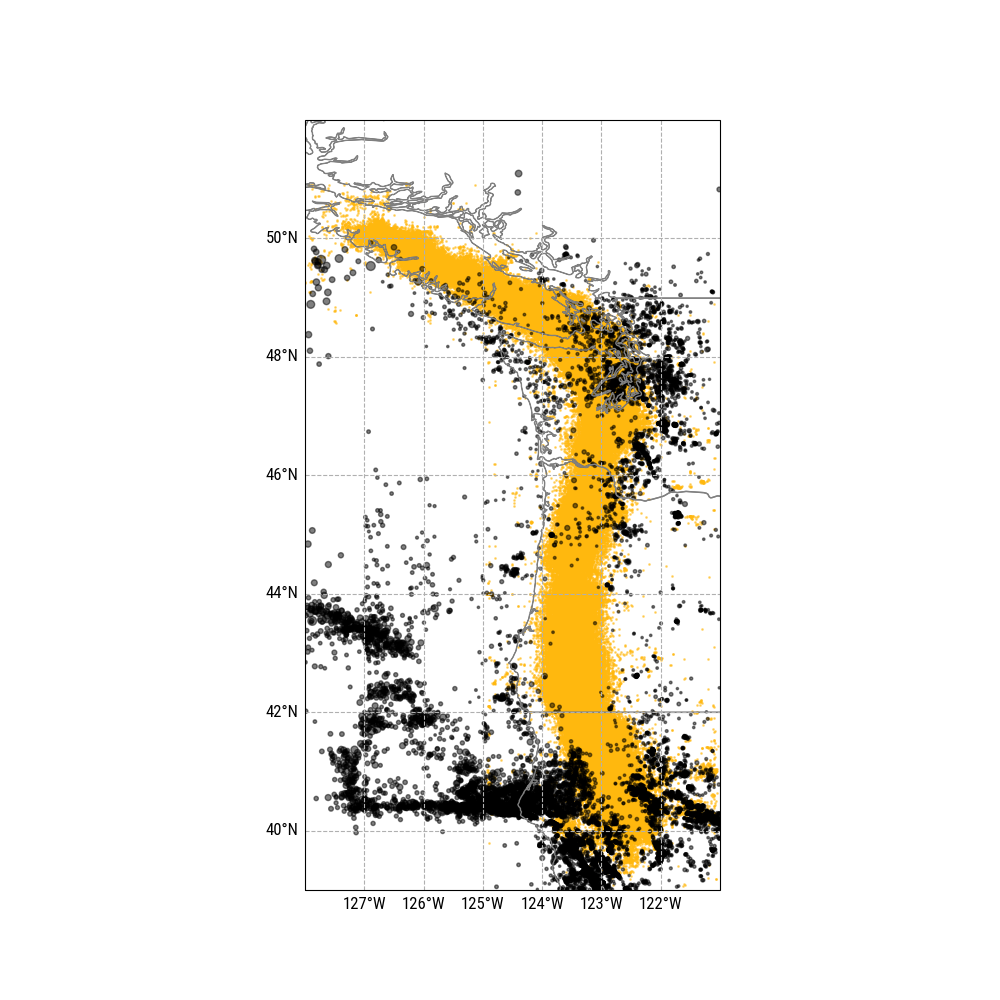

Point picked: Latitude=50.159740259740076, Longitude=-127.91883116883066
Point picked: Latitude=48.72467532467514, Longitude=-126.29805194805145
Point picked: Latitude=47.45844155844138, Longitude=-124.94740259740212
Point picked: Latitude=46.32727272727256, Longitude=-124.86298701298652
Point picked: Latitude=44.824675324675155, Longitude=-124.96428571428523
Point picked: Latitude=43.355844155844, Longitude=-125.26818181818133
Point picked: Latitude=42.44415584415569, Longitude=-125.38636363636314
Point picked: Latitude=41.549350649350494, Longitude=-124.89675324675277
Point picked: Latitude=40.637662337662185, Longitude=-124.62662337662289
Point picked: Latitude=39.74285714285699, Longitude=-124.47467532467485
Point picked: Latitude=39.08441558441544, Longitude=-124.2383116883112


In [78]:
# Map of data
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Create an empty array to store the picked locations
picked_locations = []

# Define the on_click event handler function
def on_click(event):
    if event.inaxes == ax:
        # Get the latitude and longitude of the clicked point
        lat, lon = event.ydata, event.xdata
        picked_locations.append((lat, lon))
        print(f"Point picked: Latitude={lat}, Longitude={lon}")

# Connect the on_click event handler to the figure
fig.canvas.mpl_connect('button_press_event', on_click)

# Add coastlines
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), edgecolor='black', linewidth=0.5)

# Add states
ax.add_feature(cfeature.STATES.with_scale('10m'), edgecolor='.5', linewidth=1)

# Add earthquakes
ax.scatter(eq.lon, eq.lat, s=eq.mag**2, color='k', alpha=0.5, transform=ccrs.PlateCarree(), zorder=1)

# Add tremor
ax.scatter(tremor.lon, tremor.lat, s=1, color='C2', alpha=0.5, transform=ccrs.PlateCarree(), zorder=0)

# Add gridlines
gl = ax.gridlines(draw_labels=True, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()


# Set extent for Cascadia subduction zone
extent = [-128, -121, 39, 52]
ax.set_extent(extent)

plt.show()

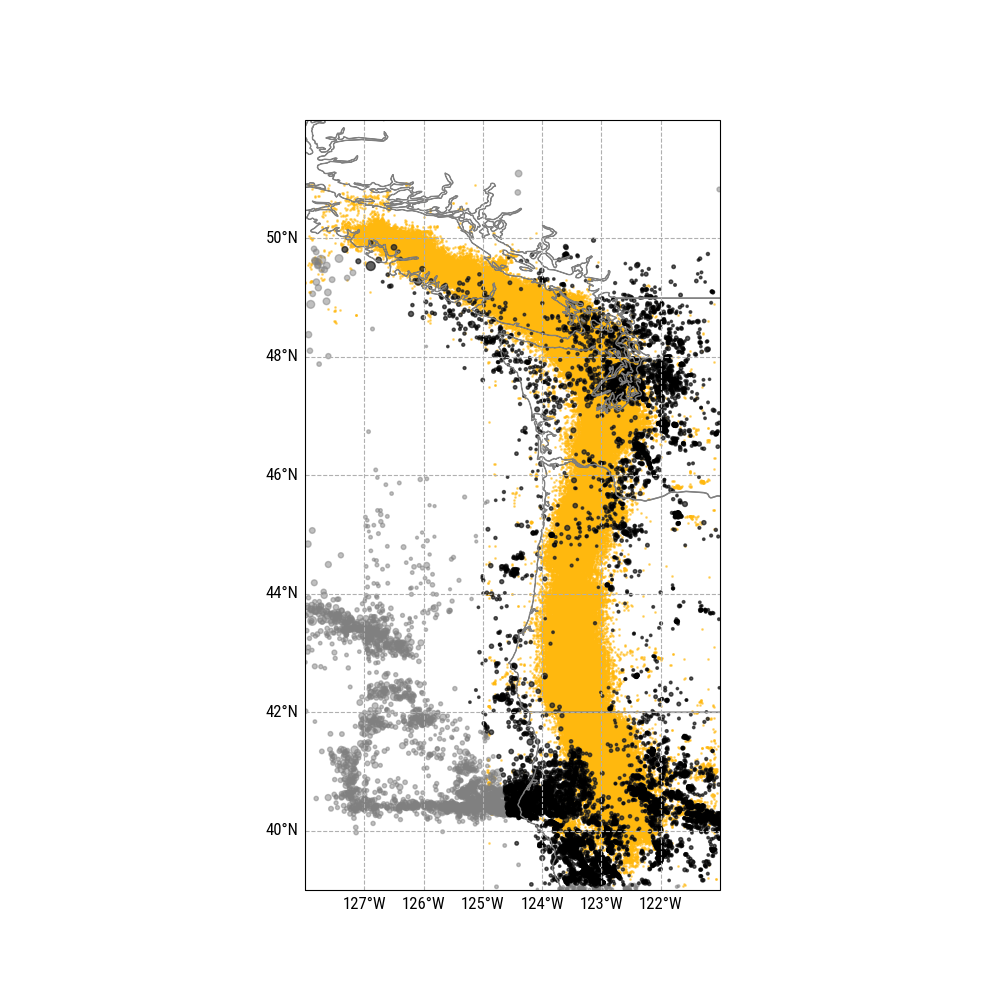

In [79]:
# Find which points are left or right of the line drawn on the map
line = picked_locations

# For each earthquake
def which_side(M, A, B):
    """"""
    return np.sign((B[0] - A[0]) * (M[1] - A[1]) - (B[1] - A[1]) * (M[0] - A[0]))

# For each earthquake, find the points of the line it's longitude is between, and then using those points, find if the earthquake is left or right of the line
eq['side'] = np.zeros(len(eq))
for ii, row in eq.iterrows():
    M = (row['lon'], row['lat'])
    for jj in range(len(line)-1):
        A = (line[jj][1], line[jj][0])
        B = (line[jj+1][1], line[jj+1][0])
        if (A[1] <= M[1] <= B[1]) or (B[1] <= M[1] <= A[1]):
            side = which_side(M, A, B)
            eq.at[ii, 'side'] = side

eq_east = eq[eq.side == 1]

%matplotlib widget
# Map of data
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Add coastlines
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), edgecolor='black', linewidth=0.5)

# Add states
ax.add_feature(cfeature.STATES.with_scale('10m'), edgecolor='.5', linewidth=1)

# Add earthquakes
ax.scatter(eq.lon, eq.lat, s=eq.mag**2, color='.5', alpha=0.5, transform=ccrs.PlateCarree(), zorder=1)
ax.scatter(eq_east.lon, eq_east.lat, s=eq_east.mag**2, color='k', alpha=0.5, transform=ccrs.PlateCarree(), zorder=1)

# Add tremor
ax.scatter(tremor.lon, tremor.lat, s=1, color='C2', alpha=0.5, transform=ccrs.PlateCarree(), zorder=0)

# Add gridlines
gl = ax.gridlines(draw_labels=True, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()

# Set extent for Cascadia subduction zone
extent = [-128, -121, 39, 52]
ax.set_extent(extent)

plt.show()

# Count earthquakes in segments along strike

In [127]:
# Define bins, and bin to check out
lat_bins = np.arange(39, 50.5, 0.5)
i_bin = 2

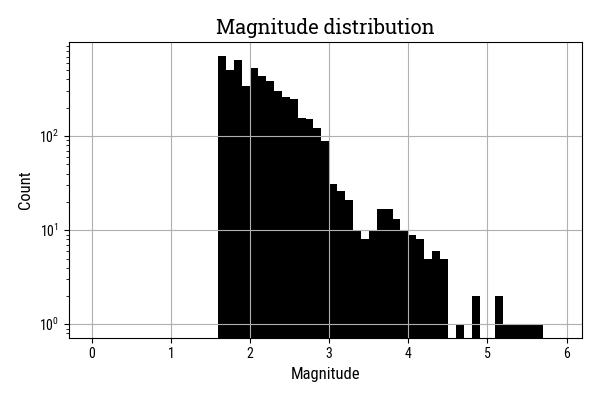

In [129]:
# Magnitude/magnitude-difference frequency distribution
fig, ax = plt.subplots(figsize=(6, 4))

indicator = (eq_east.lat >= lat_bins[i_bin]) & (eq_east.lat < lat_bins[i_bin+1])   

# --> Magnitude distribution
bins = np.arange(0, 6, 0.1)
ax.set_title('Magnitude distribution', fontname='Roboto Slab')
ax.set_xlabel('Magnitude')
ax.set_ylabel('Count')
ax.hist(eq_east.mag[indicator], bins=bins, fc='k')
ax.set_yscale('log')

ax.grid('on')

plt.tight_layout()
plt.show()

In [132]:
# Count number of magnitude 2 in each bin over the period
count_m2 = np.zeros(len(lat_bins)-1)
for ii in range(len(lat_bins)-1):
    indicator = (eq_east.lat >= lat_bins[ii]) & (eq_east.lat < lat_bins[ii+1])
    count_m2[ii] = np.sum(eq_east.mag[indicator] >= 2)


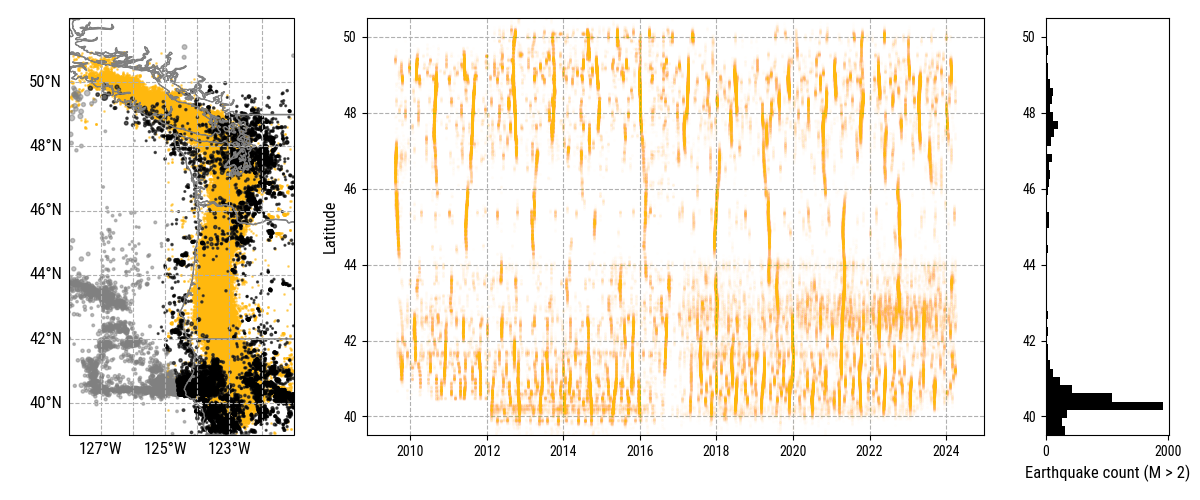

In [261]:
# Compare to tremor
fig = plt.figure(figsize=(12, 5))
gs = fig.add_gridspec(1, 3, width_ratios=[2, 5, 1])

ax = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())

# Add coastlines
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), edgecolor='black', linewidth=0.5)

# Add states
ax.add_feature(cfeature.STATES.with_scale('10m'), edgecolor='.5', linewidth=1)

# Add earthquakes
ax.scatter(eq.lon, eq.lat, s=eq.mag**2/2, color='.5', alpha=0.5, transform=ccrs.PlateCarree(), zorder=1)
ax.scatter(eq_east.lon, eq_east.lat, s=eq_east.mag**2/2, color='k', alpha=0.5, transform=ccrs.PlateCarree(), zorder=1)

# Add tremor
ax.scatter(tremor.lon, tremor.lat, s=1, color='C2', alpha=0.5, transform=ccrs.PlateCarree(), zorder=0)

# Add gridlines
gl = ax.gridlines(draw_labels=True, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()

# Set extent for Cascadia subduction zone
extent = [-128, -121, 39, 52]
ax.set_extent(extent)

ax = fig.add_subplot(gs[0, 1])
ax.set_ylabel('Latitude')
ax.set_ylim([39.5, 50.5])
ax.plot(tremor.date, tremor.lat, ls='none', marker='o', ms=2, mec=[0,0,0,0], mfc=to_rgba('C2', 1/100), label='Tremor')
ax.grid('on', zorder=-1, linestyle='--')

ax2 = fig.add_subplot(gs[0, 2])
mmin = 2

ax2.set_xlabel(f'Earthquake count (M > {mmin})')
ax.set_ylabel('Latitude')
ax2.set_ylim([39.5, 50.5])
ax2.hist(eq_east[eq_east.mag > mmin].lat, bins=50, orientation='horizontal', fc='k', zorder=1)

plt.tight_layout()
plt.show()


# Measure periodicity in tremor occurence

Detected 1856 clusters
Detected 1856 clusters
Min, median, max number of LFEs in a cluster: 15, 69.0, 15526


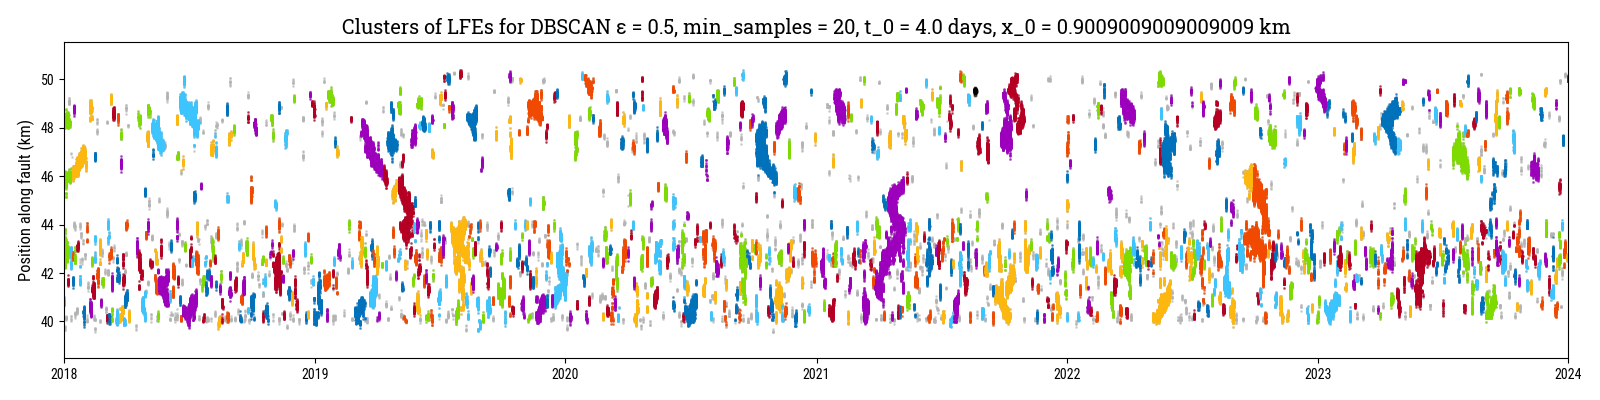

In [215]:
# Clustering
from sklearn.cluster import DBSCAN

x_tremor = tremor['lat'].values
t_tremor = tremor['day'].values

t0 = 96.* 1/24 # scaling factor for time (in days)
x0 = 100. / 111. # scaling factor for position (in km)

X = np.column_stack([x_tremor / x0, t_tremor / t0])

# Parameters for the clustering model
dbs = DBSCAN(eps=.5, min_samples=20)

# t0=48h, x0=20km, eps=.5 and min_samples=100 gives good clusters

# Fit the model
clusters_fit = dbs.fit(X)

print('Detected {:d} clusters'.format(len(np.unique(clusters_fit.labels_))))

# Stats on the clusters
print('Detected {:d} clusters'.format(len(np.unique(clusters_fit.labels_))))
print('Min, median, max number of LFEs in a cluster: {:}, {:}, {:}'.format(np.min(np.bincount(clusters_fit.labels_+1)[1:]), np.median(np.bincount(clusters_fit.labels_+1)[1:]), np.max(np.bincount(clusters_fit.labels_+1)[1:])))

# Show clusters
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax.set_title('Clusters of LFEs for DBSCAN ε = {:}, min_samples = {:}, t_0 = {:} days, x_0 = {:} km'.format(dbs.eps, dbs.min_samples, t0, x0), fontname='Roboto Slab')
ax.set_ylabel('Position along fault (km)')
ax.set_xlim(np.datetime64('2018-01-01'), np.datetime64('2024-01-01'))

ax.plot(tremor.date, tremor.lat, 'o', ms=1, alpha=0.5, c='.7')

for cluster in np.unique(clusters_fit.labels_):
    if cluster == -1:
        continue
    idx = clusters_fit.labels_ == cluster
    ax.plot(tremor.date.values[idx], tremor.lat.values[idx], 'o', ms=1, alpha=0.5)

plt.tight_layout()
plt.show()

In [233]:
# Make clusters dataframe
tremor['cluster_id'] = clusters_fit.labels_

# Group LFEs by cluster ID
cluster_groups = tremor.groupby('cluster_id')

# Initialize an empty dataframe to store cluster information
clusters_df = pd.DataFrame(columns=['id',
                                    'n_ev',
                                    't_first',
                                    't_last',
                                    'lat_min',
                                    'lat_max',
                                    'z_min',
                                    'z_max',
                                    't_centroid',
                                    'lat_centroid',
                                    'z_centroid',
                                    't_first80',
                                    't_last80',
                                    'duration80'])

# Loop over the cluster groups and compute statistics for each cluster
for cluster_id, cluster_data in cluster_groups:
    if cluster_id == -1:
        continue
    n_ev = len(cluster_data)
    t_first = cluster_data['date'].min()
    t_last = cluster_data['date'].max()
    lat_min = cluster_data['lat'].min()
    lat_max = cluster_data['lat'].max()
    z_min = cluster_data['depth'].min()
    z_max = cluster_data['depth'].max()
    t_centroid = np.percentile(cluster_data['date'], 50)
    lat_centroid = np.median(cluster_data['lat'])
    z_centroid = np.median(cluster_data['depth'])
    t_first80 = np.percentile(cluster_data['date'], 10)
    t_last80 = np.percentile(cluster_data['date'], 90)
    duration80 = (t_last80 - t_first80) / np.timedelta64(1, 's')  # in seconds

    # Add cluster information to the dataframe
    clusters_df.loc[len(clusters_df)] = [cluster_id, n_ev, t_first, t_last, lat_min, lat_max, z_min, z_max, t_centroid, lat_centroid, z_centroid, t_first80, t_last80, duration80]

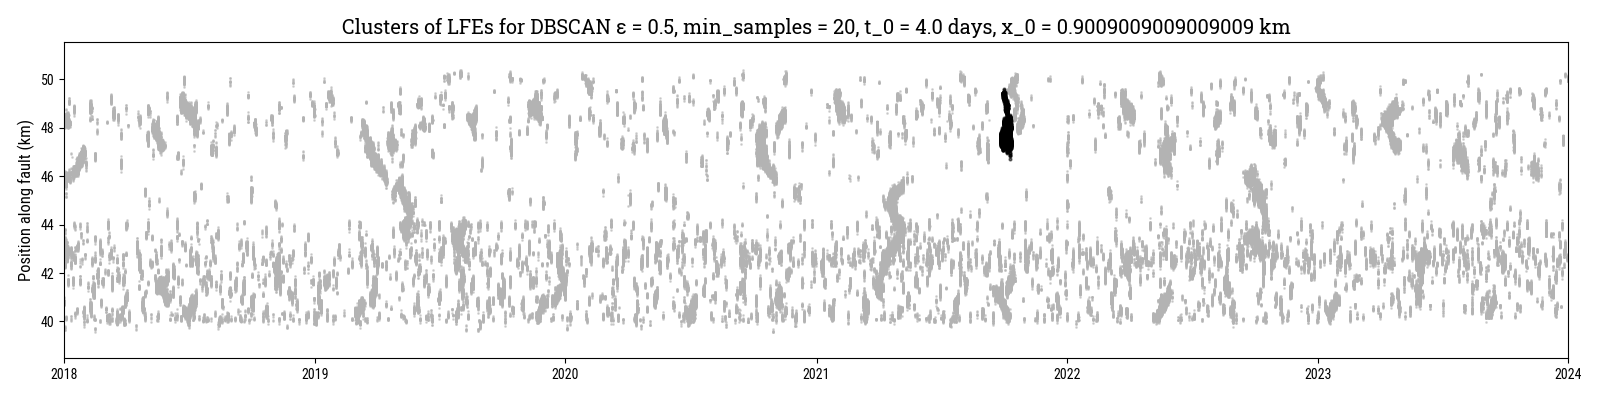

In [231]:
# Show clusters
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax.set_title('Clusters of LFEs for DBSCAN ε = {:}, min_samples = {:}, t_0 = {:} days, x_0 = {:} km'.format(dbs.eps, dbs.min_samples, t0, x0), fontname='Roboto Slab')
ax.set_ylabel('Position along fault (km)')
ax.set_xlim(np.datetime64('2018-01-01'), np.datetime64('2024-01-01'))

ax.plot(tremor.date, tremor.lat, 'o', ms=1, alpha=0.5, c='.7')

idx_hl = clusters_fit.labels_ == 1515
ax.plot(tremor.date.values[idx_hl], tremor.lat.values[idx_hl], 'ko', ms=2, alpha=0.5)

plt.tight_layout()
plt.show()
